## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path = F"/gdrive/MyDrive/4classes.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.4530,  0.5955, -1.1069,  ...,  0.5985,  0.1790,  0.2985],
         [ 0.2027,  0.6537,  0.6290,  ..., -0.1876, -1.2782,  0.5982],
         [-0.2713,  0.4418,  1.5845,  ..., -1.1430, -2.2012,  0.7388],
         ...,
         [ 0.5176, -1.6871, -1.4386,  ..., -0.2084,  1.3068, -0.1615],
         [ 0.0700, -1.4413, -0.2656,  ..., -0.3264,  1.0155,  0.4870],
         [-0.2865,  1.4095,  1.7289,  ..., -0.3547, -1.7226,  0.7805]]),
 'edge_index': tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  2,  4,  4,  4,  4,  5,  5,  6,  6,  6,
           6,  6,  6,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10,
          11, 11, 11, 11, 11, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
          14, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 21,
          21, 21, 22, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26,
          27, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 32, 32,
          33, 34, 34, 34, 34, 34, 34, 35, 36, 3

In [ ]:
path = F"/gdrive/MyDrive/4classes.sim/p_link.pt"
p_link = torch.load(path)
print(p_link)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0900, 0.0000],
        [0.0000, 1.0000, 0.2000,  ..., 0.6900, 0.0200, 0.2100],
        [0.0000, 0.2000, 1.0000,  ..., 0.0300, 0.0300, 0.0100],
        ...,
        [0.0200, 0.6900, 0.0300,  ..., 1.0000, 0.1600, 0.5800],
        [0.0900, 0.0200, 0.0300,  ..., 0.1600, 1.0000, 0.2000],
        [0.0000, 0.2100, 0.0100,  ..., 0.5800, 0.2000, 1.0000]])
torch.Size([40, 40])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 27.6 MB/s 
     |████████████████████████████████| 4.6 MB 28.6 MB/s 


# Create BGAT and GAT layers. 

In [ ]:
from torch_geometric.nn import MessagePassing
import torch_geometric.nn
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import GATConv

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x=x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

In [ ]:
class Myconv_BGAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 50)
        self.conv2 =  BGATConv(50, 10)
        self.conv3 =  BGATConv(10, 4)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        
model_BGAT = Myconv_BGAT()
print(model_BGAT)
print(model_BGAT.forward(Data["x"], Data["edge_index"]))

Myconv_BGAT(
  (conv1): BGATConv(500, 50)
  (conv2): BGATConv(50, 10)
  (conv3): BGATConv(10, 4)
)
tensor([[ -2.8707,  -3.4974,  -0.1526,  -2.9075],
        [ -1.0652,  -1.9093,  -1.5955,  -1.1896],
        [ -2.1635,  -3.3861,  -0.3989,  -1.7140],
        [ -1.3228,  -1.4786,  -1.5151,  -1.2521],
        [ -2.0014,  -0.6609,  -1.0544,  -9.5835],
        [ -2.0046,  -2.8759,  -0.6233,  -1.2992],
        [ -2.8296,  -0.2859,  -1.6626, -12.7543],
        [ -1.1789,  -1.5411,  -1.6864,  -1.2275],
        [ -2.8913,  -0.2720,  -1.7003, -13.0820],
        [ -2.4686,  -0.4631,  -1.2520, -11.6449],
        [ -1.4750,  -1.7880,  -0.9600,  -1.5094],
        [ -0.9170,  -1.2654,  -1.9920,  -1.7053],
        [ -1.4784,  -2.0022,  -0.9031,  -1.4624],
        [ -2.7180,  -2.9736,  -0.2210,  -2.5118],
        [ -2.8403,  -0.2415,  -1.8570, -14.6291],
        [ -1.3367,  -1.5211,  -1.3278,  -1.3714],
        [ -1.6430,  -2.3355,  -0.8739,  -1.2291],
        [ -3.4319,  -4.1346,  -0.0958,  -3.1470],
 

<ipython-input-10-821b25de8f36>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


In [ ]:
class Myconv_GAT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = GATConv(in_channels = 500, out_channels = 8)
        self.conv2 =  GATConv(8,4)

        

    def forward(self, x, edge_index):
        f = self.conv1(x, edge_index)
        f = F.torch.tanh(f)
        f = self.conv2(f, edge_index)# Final GNN embedding space.
        f = F.log_softmax(f)
        return f
        

model_GAT = Myconv_GAT()
print(model_GAT)
print(model_GAT.forward(Data["x"], Data["edge_index"]))

Myconv_GAT(
  (conv1): GATConv(500, 8, heads=1)
  (conv2): GATConv(8, 4, heads=1)
)
tensor([[-1.4782, -3.2267, -1.6484, -0.6164],
        [-2.0163, -2.9077, -1.6430, -0.4799],
        [-0.9537, -1.8489, -2.1233, -1.0858],
        [-2.5058, -2.3223, -0.3816, -1.9836],
        [-1.0091, -2.2511, -1.4071, -1.2542],
        [-1.2715, -1.9648, -2.0565, -0.7952],
        [-0.9781, -2.0685, -1.6489, -1.1863],
        [-1.2810, -0.7253, -2.0576, -2.2048],
        [-0.9781, -2.0685, -1.6489, -1.1863],
        [-1.0504, -2.1256, -1.5886, -1.1190],
        [-1.4075, -1.5120, -1.7793, -1.0051],
        [-1.8909, -2.5580, -1.5674, -0.5744],
        [-0.4946, -1.8777, -2.1263, -2.1373],
        [-1.4524, -2.7654, -1.5383, -0.7168],
        [-1.1531, -2.7234, -1.3636, -1.0135],
        [-1.4762, -1.8212, -1.0878, -1.2994],
        [-1.2769, -2.0969, -2.1223, -0.7371],
        [-1.4118, -3.4797, -1.4304, -0.7210],
        [-2.0807, -2.8264, -1.6534, -0.4707],
        [-1.5796, -2.4318, -1.4956, -0.729

<ipython-input-11-3c123f49bc3d>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(f)


# Train BGAT and GAT models. 

In [ ]:
model = Myconv_BGAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_BGAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_BGAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_BGAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_BGAT

train_loss_BGAT_ = []
for epoch in range(1, 201):
  epoch_train_lossBGAT = []
  train_loss_BGAT = train_BGAT(Data)
  epoch_train_lossBGAT.append(train_loss_BGAT.item())
  train_loss_BGAT_.append(sum(epoch_train_lossBGAT)/len(epoch_train_lossBGAT))
  print(f'Train_BGAT:  {train_loss_BGAT:.3f}')  

<ipython-input-10-821b25de8f36>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


Train_BGAT:  1.478
Train_BGAT:  0.957
Train_BGAT:  0.624
Train_BGAT:  0.415
Train_BGAT:  0.288
Train_BGAT:  0.214
Train_BGAT:  0.169
Train_BGAT:  0.141
Train_BGAT:  0.121
Train_BGAT:  0.107
Train_BGAT:  0.096
Train_BGAT:  0.087
Train_BGAT:  0.080
Train_BGAT:  0.074
Train_BGAT:  0.069
Train_BGAT:  0.064
Train_BGAT:  0.060
Train_BGAT:  0.057
Train_BGAT:  0.054
Train_BGAT:  0.051
Train_BGAT:  0.049
Train_BGAT:  0.047
Train_BGAT:  0.045
Train_BGAT:  0.044
Train_BGAT:  0.043
Train_BGAT:  0.042
Train_BGAT:  0.041
Train_BGAT:  0.040
Train_BGAT:  0.039
Train_BGAT:  0.038
Train_BGAT:  0.038
Train_BGAT:  0.037
Train_BGAT:  0.037
Train_BGAT:  0.036
Train_BGAT:  0.036
Train_BGAT:  0.035
Train_BGAT:  0.035
Train_BGAT:  0.035
Train_BGAT:  0.034
Train_BGAT:  0.034
Train_BGAT:  0.034
Train_BGAT:  0.033
Train_BGAT:  0.033
Train_BGAT:  0.033
Train_BGAT:  0.032
Train_BGAT:  0.032
Train_BGAT:  0.032
Train_BGAT:  0.032
Train_BGAT:  0.032
Train_BGAT:  0.031
Train_BGAT:  0.031
Train_BGAT:  0.031
Train_BGAT: 

In [ ]:
model = Myconv_GAT()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train_GAT(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss_GAT = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss_GAT.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss_GAT

train_loss_GAT_ = []
for epoch in range(1, 201):
  epoch_train_lossGAT = []
  train_loss_GAT = train_GAT(Data)
  epoch_train_lossGAT.append(train_loss_GAT.item())
  train_loss_GAT_.append(sum(epoch_train_lossGAT)/len(epoch_train_lossGAT))
  print(f'Train_GAT:  {train_loss_GAT:.3f}')    

Train_GAT:  1.686
Train_GAT:  1.583
Train_GAT:  1.483
Train_GAT:  1.389
Train_GAT:  1.304
Train_GAT:  1.229
Train_GAT:  1.158
Train_GAT:  1.088
Train_GAT:  1.023
Train_GAT:  0.961
Train_GAT:  0.902
Train_GAT:  0.846
Train_GAT:  0.793
Train_GAT:  0.745
Train_GAT:  0.700
Train_GAT:  0.658
Train_GAT:  0.620


<ipython-input-11-3c123f49bc3d>:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(f)


Train_GAT:  0.584
Train_GAT:  0.551
Train_GAT:  0.521
Train_GAT:  0.492
Train_GAT:  0.466
Train_GAT:  0.442
Train_GAT:  0.419
Train_GAT:  0.399
Train_GAT:  0.380
Train_GAT:  0.364
Train_GAT:  0.349
Train_GAT:  0.335
Train_GAT:  0.322
Train_GAT:  0.311
Train_GAT:  0.301
Train_GAT:  0.291
Train_GAT:  0.283
Train_GAT:  0.276
Train_GAT:  0.269
Train_GAT:  0.262
Train_GAT:  0.257
Train_GAT:  0.251
Train_GAT:  0.247
Train_GAT:  0.242
Train_GAT:  0.237
Train_GAT:  0.233
Train_GAT:  0.229
Train_GAT:  0.225
Train_GAT:  0.222
Train_GAT:  0.218
Train_GAT:  0.215
Train_GAT:  0.211
Train_GAT:  0.208
Train_GAT:  0.205
Train_GAT:  0.202
Train_GAT:  0.199
Train_GAT:  0.196
Train_GAT:  0.193
Train_GAT:  0.190
Train_GAT:  0.188
Train_GAT:  0.185
Train_GAT:  0.183
Train_GAT:  0.181
Train_GAT:  0.178
Train_GAT:  0.176
Train_GAT:  0.174
Train_GAT:  0.172
Train_GAT:  0.171
Train_GAT:  0.169
Train_GAT:  0.167
Train_GAT:  0.166
Train_GAT:  0.164
Train_GAT:  0.163
Train_GAT:  0.162
Train_GAT:  0.161
Train_GAT:

# Visualize train_loss for both models. 

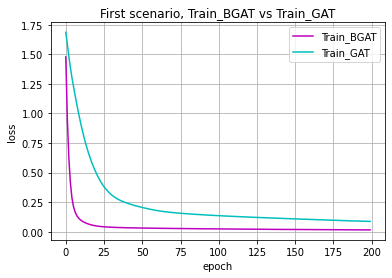

In [ ]:
import matplotlib.pyplot as plt
#X = np.arange(0, 100, 1)
plt.plot(train_loss_BGAT_, "m")
plt.plot(train_loss_GAT_, "c")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train_BGAT','Train_GAT'])
plt.title('First scenario, Train_BGAT vs Train_GAT')
plt.grid()
plt.show()